# RAG Evaluation Experiment Loop

This notebook reproduces the workflow in [rag_experiment_evaluation.ipynb](rag_experiment_evaluation.ipynb) through a series of functions. 

These functions allow us to loop through a CSV of experiments in order to systematically change prompts and measure the results.


### 1. Import required packages up-front

In [6]:
# Add autoreloatd
%reload_ext autoreload
%autoreload 2

from jose import jwt
from uuid import UUID
import requests
import json
import pandas as pd
import pickle
from dataclasses import asdict
from IPython.display import clear_output
from pathlib import Path

from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())

import os
cwd = os.getcwd()
os.chdir('../../')
from redbox.models import Settings
os.chdir(cwd)

from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_elasticsearch import ApproxRetrievalStrategy, ElasticsearchStore
from langchain_community.chat_models import ChatLiteLLM
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.chains.llm import LLMChain
from langchain.prompts.prompt import PromptTemplate
from langchain.globals import set_verbose

from deepeval.dataset import EvaluationDataset
from deepeval import evaluate
from deepeval.metrics import (
    ContextualPrecisionMetric,
    ContextualRecallMetric,
    ContextualRelevancyMetric,
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    HallucinationMetric,
)


/Users/euansoutter/Documents/code/redbox-copilot/.venv/lib/python3.11/site-packages/deepeval/__init__.py:42: UserWarning: You are using deepeval version 0.21.48, however version 0.21.57 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


### 2. Set evaluation data version

In [ ]:
DATA_VERSION = "0.2.1"


### 3. Set paths

In [ ]:
ROOT = Path.cwd().parents[1]
EVALUATION_DIR = ROOT / "notebooks/evaluation"

V_ROOT = EVALUATION_DIR / f"data/{DATA_VERSION}"
V_RAW = V_ROOT / "raw"
V_SYNTHETIC = V_ROOT / "synthetic"
V_CHUNKS = V_ROOT / "chunks"
V_RESULTS = V_ROOT / "results"

V_ROOT.mkdir(parents=True, exist_ok=True)
V_RAW.mkdir(parents=True, exist_ok=True)
V_SYNTHETIC.mkdir(parents=True, exist_ok=True)
V_CHUNKS.mkdir(parents=True, exist_ok=True)
V_RESULTS.mkdir(parents=True, exist_ok=True)

### 4. Define function to get RAG outputs based on prompts in experiments

In [ ]:
def get_rag_outputs(V_SYNTHETIC, EXPERIMENT_NAME, WITH_SOURCES_PROMPT, STUFF_DOCUMENT_PROMPT, CONDENSE_QUESTION_PROMPT):
    
    set_verbose(False)

    ####### Core variables

    ENV = Settings()
    ENV.elastic.host = "localhost"
    LLM = ChatLiteLLM(
        model="gpt-3.5-turbo",
        streaming=True,
    )
    EMBEDDING_MODEL = SentenceTransformerEmbeddings(model_name=ENV.embedding_model)
    VECTOR_STORE = ElasticsearchStore(
        es_connection=ENV.elasticsearch_client(),
        index_name="redbox-data-chunk",
        embedding=EMBEDDING_MODEL,
        strategy=ApproxRetrievalStrategy(hybrid=False),
        vector_query_field="embedding",
    )
    RETRIEVER = VECTOR_STORE.as_retriever(
        search_kwargs={
            "filter": {
                "term": {
                    "creator_user_uuid.keyword": str(UUID("aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa"))
                }
            }
        }
    )

    ####### RAG function

    def rag_chat(question: str, previous_history: list[tuple[str, str]] | None = None) -> str:
        docs_with_sources_chain = load_qa_with_sources_chain(
            LLM,
            chain_type="stuff",
            prompt=PromptTemplate.from_template(WITH_SOURCES_PROMPT),
            document_prompt=PromptTemplate.from_template(STUFF_DOCUMENT_PROMPT),
            verbose=True,
        )

        condense_question_chain = LLMChain(
            llm=LLM, 
            prompt=PromptTemplate.from_template(CONDENSE_QUESTION_PROMPT),
            verbose=False
        )

        standalone_question = condense_question_chain(
            {"question": question, "chat_history": previous_history}
        )["text"]

        docs = RETRIEVER.get_relevant_documents(standalone_question)

        result = docs_with_sources_chain(
            {
                "question": standalone_question,
                "input_documents": docs,
            },
        )

        source_documents = [
            {
                "page_content": langchain_document.page_content,
                "file_uuid": langchain_document.metadata.get("parent_doc_uuid"),
                "page_numbers": langchain_document.metadata.get("page_numbers"),
            }
            for langchain_document in result.get("input_documents", [])
        ]

        return {
            "output_text": result["output_text"],
            "source_documents": source_documents
        }


    ########

    df = pd.read_csv(f'{V_SYNTHETIC}/ragas_synthetic_data.csv')
    inputs = df['input'].tolist()
    
    df_function = df.copy()

    retrieval_context = []
    actual_output = []

    for question in inputs:
        data = rag_chat(question=question, previous_history=None)

        retrieval_context.append(data['source_documents'])
        actual_output.append(data['output_text'])

    df_function['actual_output'] = actual_output
    df_function['retrieval_context'] = retrieval_context

    clear_output()

    df_function_clean = df_function.dropna()
    df_function_clean.to_csv(f'{V_SYNTHETIC}/{EXPERIMENT_NAME}_complete_ragas_synthetic_data.csv', index=False)


### 5. Define function to evaluation test dataset 

In [ ]:
def do_evaluation(V_SYNTHETIC, V_RESULTS, EXPERIMENT_NAME):

    dataset = EvaluationDataset()
    dataset.add_test_cases_from_csv_file(
        file_path=f'{V_SYNTHETIC}/{EXPERIMENT_NAME}_complete_ragas_synthetic_data.csv', # function
        input_col_name="input",
        actual_output_col_name="actual_output",
        expected_output_col_name="expected_output",
        context_col_name="context",
        context_col_delimiter= ";",
        retrieval_context_col_name="retrieval_context",
        retrieval_context_col_delimiter= ";"
    )

    # Instantiate retrieval metrics
    contextual_precision = ContextualPrecisionMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    contextual_recall = ContextualRecallMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    contextual_relevancy = ContextualRelevancyMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    # Instantiate generation metrics
    answer_relevancy = AnswerRelevancyMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    faithfulness = FaithfulnessMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    hallucination = HallucinationMetric(
        threshold=0.5, # default is 0.5
        model="gpt-4o",
        include_reason=True
    )

    eval_results = evaluate(
        test_cases=dataset,
        metrics=[
            contextual_precision,
            contextual_recall,
            contextual_relevancy,
            answer_relevancy,
            faithfulness,
            hallucination
        ]
    )

    with open(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results", "wb") as f:
        pickle.dump(eval_results, f)

    with open(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results", "rb") as f:
        eval_results = pickle.load(f)

    metric_type = {
    "metric_name": ["Contextual Precision", "Contextual Recall", "Contextual Relevancy", "Answer Relevancy", "Faithfulness", "Hallucination"],
    "metric_type": ["retrieval", "retrieval", "retrieval", "generation", "generation", "generation"]}

    evaluation = (
        pd.DataFrame.from_records(
            asdict(result) for result in eval_results
        )
        .explode("metrics")
        .reset_index(drop=True)
        .assign(
            metric_name = lambda df: df.metrics.apply(getattr, args=["__name__"]),
            score = lambda df: df.metrics.apply(getattr, args=["score"]),
            reason = lambda df: df.metrics.apply(getattr, args=["reason"])
        )
        .merge(
            pd.DataFrame(metric_type),
            on="metric_name"
        )
        .drop(columns=["success"])
    )

    evaluation.to_csv(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results.csv", index=False)
    evaluation.head()
        
    return evaluation

### 6. Load CSV of experiments

In [ ]:
experiment_list = pd.read_csv('data/experiment_parameters/prompt_chunk_experiment_dataset.csv')

# experiment_list = experiment_list[(experiment_list.experiment_name == 'original_prompt') |
#                                   (experiment_list.experiment_name == 'simplified_prompt')]

experiment_list = experiment_list[experiment_list.experiment_name == 'really_simple_prompt']

### 7. Loop through experiments and pass parameters to each function, returning the concantenated evaluation results.

In [ ]:
experiment_list = pd.read_csv('data/experiment_parameters/prompt_chunk_experiment_dataset.csv')

# experiment_list = experiment_list[(experiment_list.experiment_name == 'original_prompt') |
#                                   (experiment_list.experiment_name == 'simplified_prompt')]

experiment_list = experiment_list[experiment_list.experiment_name == 'really_simple_prompt']

evaluations = []

for index, row in experiment_list.iterrows():

    EXPERIMENT_NAME = row["experiment_name"]
    WITH_SOURCES_PROMPT = row["with_sources_prompt"]
    STUFF_DOCUMENT_PROMPT = row["stuff_document_prompt"]
    CONDENSE_QUESTION_PROMPT = row["condense_question_prompt"]
    CHUNK_SIZE = row['chunk_size']

    get_rag_outputs(V_SYNTHETIC, EXPERIMENT_NAME, WITH_SOURCES_PROMPT, STUFF_DOCUMENT_PROMPT, CONDENSE_QUESTION_PROMPT)

    evaluation = do_evaluation(V_SYNTHETIC, V_RESULTS, EXPERIMENT_NAME)

    evaluations.append(evaluation) 

### 8. Load and visualise results

,experiment_name,metric_name,mean,sem,min,max,count,ci_low,ci_high
0,baseline,Answer Relevancy,0.834934,0.022837,0.500000,1.0,29,0.788155,0.881714
1,baseline,Contextual Precision,0.810345,0.058619,0.000000,1.0,29,0.690268,0.930421
2,baseline,Contextual Recall,0.741092,0.062951,0.000000,1.0,29,0.612144,0.870040
3,baseline,Contextual Relevancy,0.556897,0.085807,0.000000,1.0,29,0.381129,0.732664
4,baseline,Faithfulness,0.964943,0.014665,0.750000,1.0,29,0.934902,0.994983
5,baseline,Hallucination,0.195019,0.060105,0.000000,1.0,29,0.071899,0.318139
6,original_prompt,Answer Relevancy,0.803849,0.036055,0.000000,1.0,30,0.730109,0.877589
7,original_prompt,Contextual Precision,0.757407,0.062808,0.000000,1.0,30,0.628951,0.885864
8,original_prompt,Contextual Recall,0.736111,0.064555,0.000000,1.0,30,0.604081,0.868141
9,original_prompt,Contextual Relevancy,0.591667,0.087661,0.000000,1.0,30,0.412381,0.770953


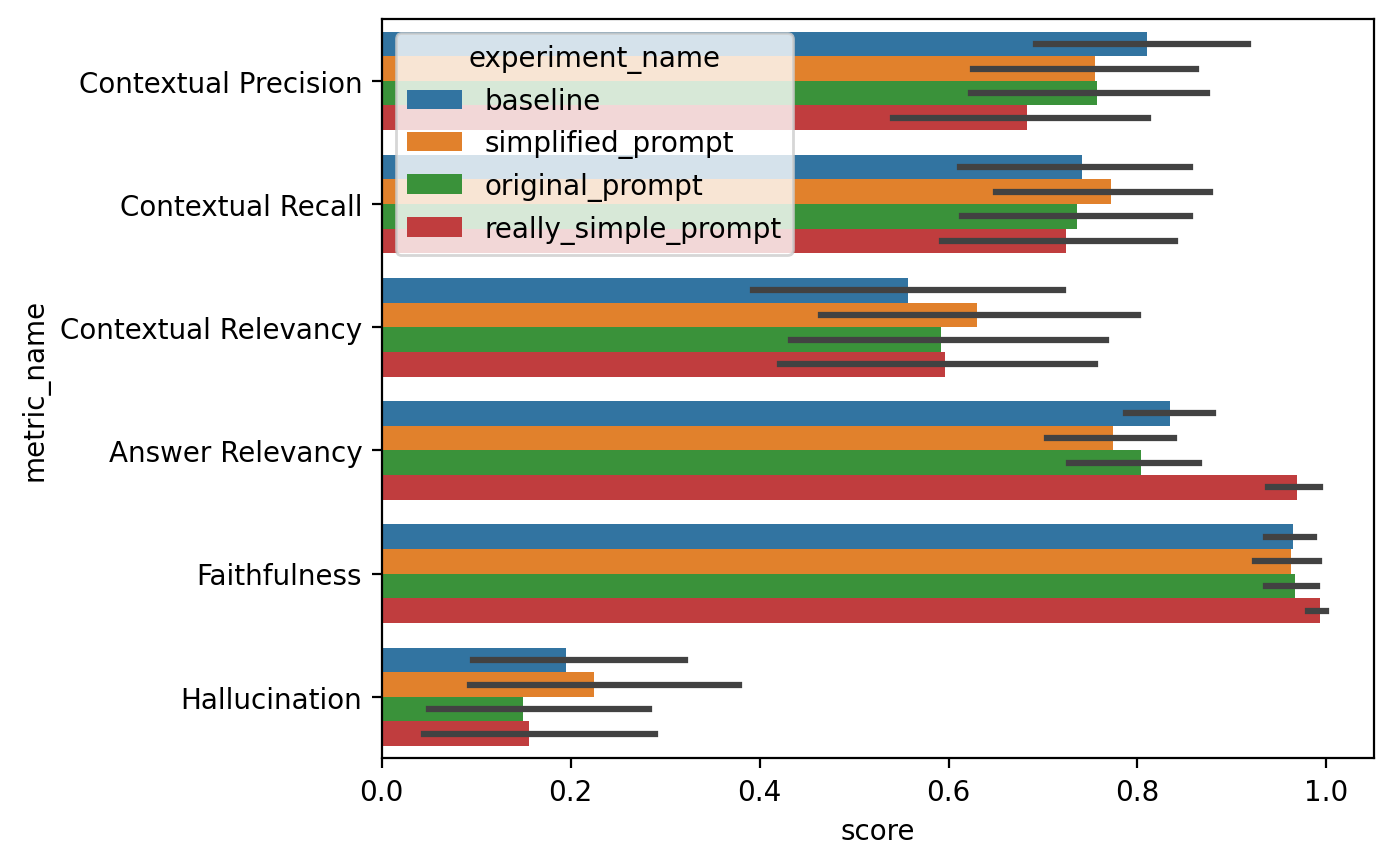

In [18]:
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import seaborn as sns

experiments = []

baseline = pd.read_csv(f"{V_RESULTS}/baseline.csv")
baseline['experiment_name'] = 'baseline'
experiments.append(baseline)

# Comment out if you only want to view baseline statistics
# Populate with experiment names
experiment_names = ['simplified_prompt', 'original_prompt', 'really_simple_prompt']
for experiment_name in experiment_names:
    experiment = pd.read_csv(f"{V_RESULTS}/{experiment_name}_generation_eval_results.csv")
    experiment['experiment_name'] = experiment_name
    experiments.append(experiment)

experiments_df = pd.concat(experiments)

def empirical_ci(df):

    df_grouped = (df
                  .groupby(["experiment_name", "metric_name"])['score']
                  .agg(["mean", 'sem', 'min', 'max', 'count'])
                  .reset_index()
                  )
        
    ci = stats.t.interval(confidence=0.95, 
                          df=df_grouped['count']-1,
                          loc=df_grouped['mean'],
                          scale=df_grouped['sem'])

    df_grouped['ci_low'] = ci[0]
    df_grouped['ci_high'] = ci[1] 

    return df_grouped

# Note that the confidence intervals in sns.barplot is calculated by bootstrapping. 
# See empirical_ci() above for empirical confidence interval calculation. 
sns.barplot(experiments_df, x="score", y="metric_name", hue='experiment_name', errorbar=('ci', 95))

empirical_ci(experiments_df)